<a href="https://colab.research.google.com/github/NsiriRoua/Yoga-Pose-Estimation/blob/main/Yoga_Poses_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import necssary libraries :**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from PIL import Image
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications import VGG16, InceptionResNetV2 , VGG19
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
train_dir = '/content/drive/MyDrive/Human Motion Analysis for Fitness & Health/DATASET/TRAIN'
test_dir = '/content/drive/MyDrive/Human Motion Analysis for Fitness & Health/DATASET/TRAIN'

# **Visualize the Data with its Labels**

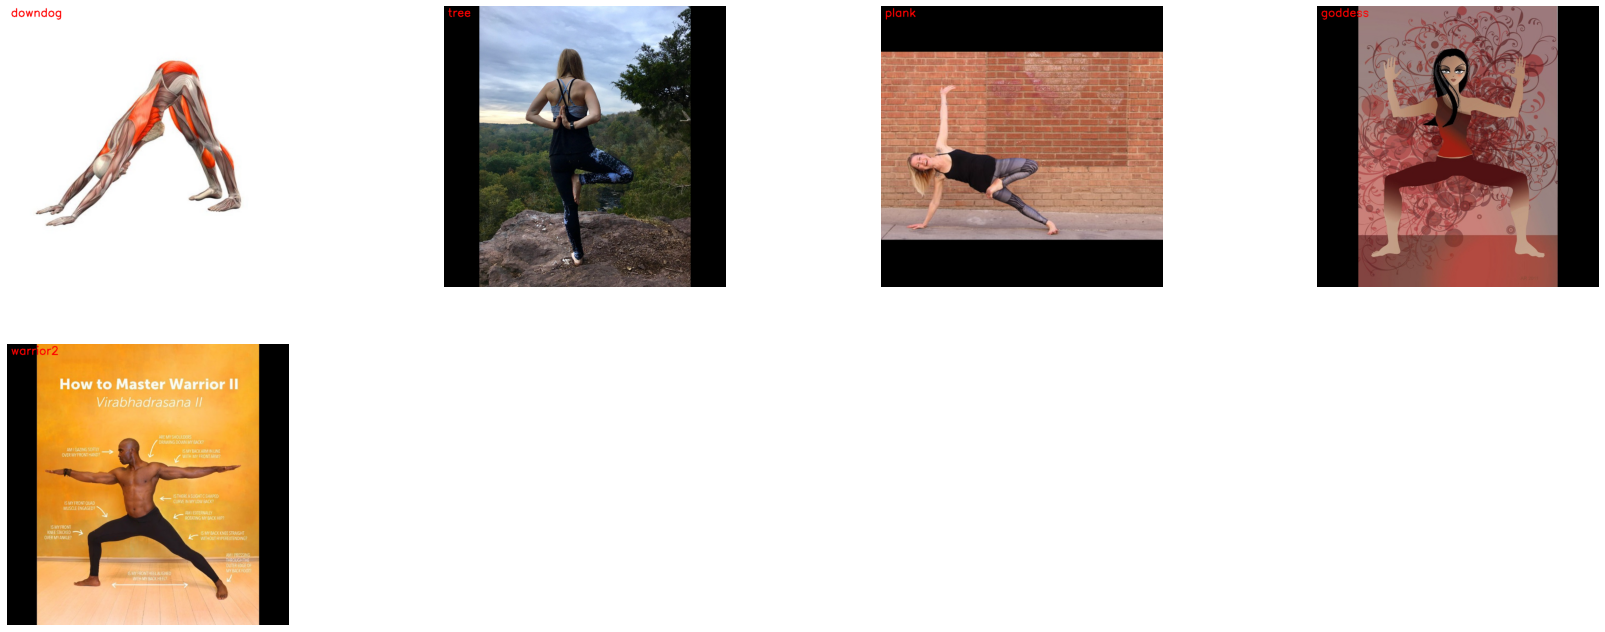

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir(train_dir)

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 5)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'/content/drive/MyDrive/Human Motion Analysis for Fitness & Health/DATASET/TRAIN/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/Human Motion Analysis for Fitness & Health/DATASET/TRAIN/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

# **Data Augmentation :**

In [ ]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                  horizontal_flip = True,
                                  rescale = 1./255,
                                  validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale =1./255,
                                 validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (224,224),
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical',
                                                    batch_size = 16,
                                                   subset = 'training')
validation_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                       target_size = (224,224),
                                                       color_mode = 'rgb',
                                                       class_mode = 'categorical',
                                                       batch_size = 16,
                                                       subset = 'validation')

Found 866 images belonging to 5 classes.
Found 92 images belonging to 5 classes.


# **Build Model : VGG19**

In [ ]:
model = tf.keras.Sequential()
model.add(VGG19(include_top = False,weights = 'imagenet',input_shape= (224,224,3)))
model.add(Flatten())
model.add(Dense(5,activation = 'softmax'))

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
optimizer = Adam(lr = 0.0001)
model.compile(loss = "categorical_crossentropy",optimizer = optimizer,metrics = [dice_coef,'accuracy'])
epochs = 25
batch_size = 16

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = 'yoga_pose_estimation_vgg19.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [ ]:
history = model.fit(train_generator, epochs = epochs,validation_data = validation_generator,callbacks=callbacks)

In [ ]:
model.load_weights("./yoga_pose_estimation_vgg19.h5")

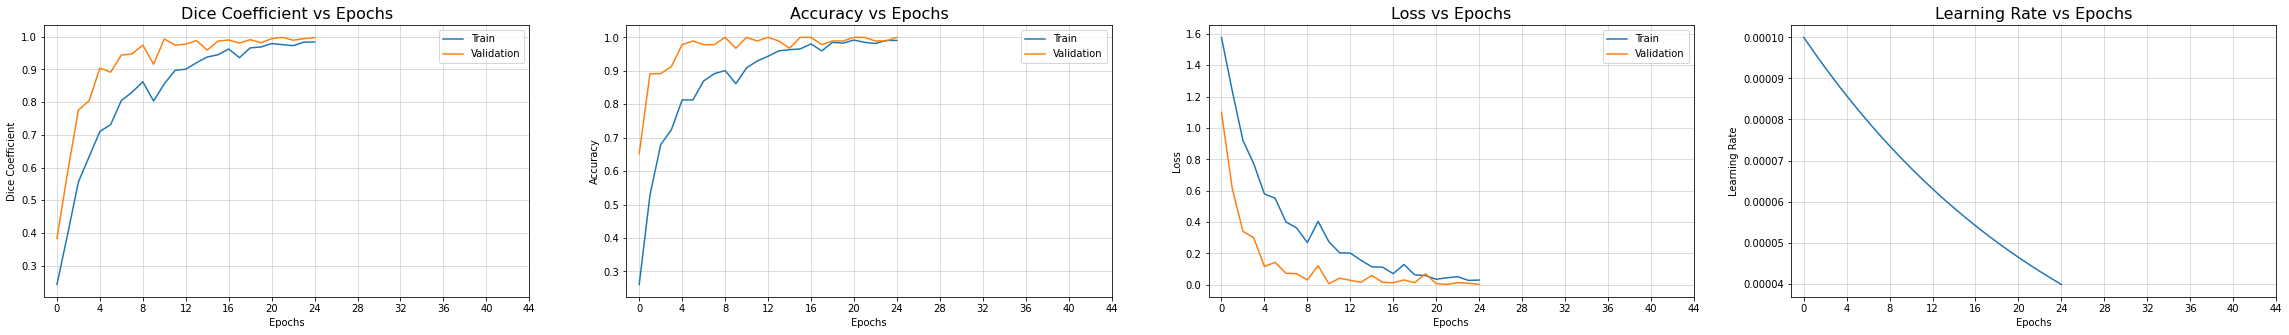

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(40, 5))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss', 'Learning Rate']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss', 'lr']): 
    if met != 'lr':
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].legend(['Train', 'Validation'])
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    else:
        ax[i].plot(history.history[met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        
plt.savefig('model_metrics_plot.png', facecolor= 'w',transparent= False, bbox_inches= 'tight', dpi= 150)

In [ ]:
import pandas as pd
df_result = pd.DataFrame(history.history)
df_result

In [ ]:
df_result.to_csv('vgg19_results.csv')

# **Build Model : InceptionResNetV2**

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
model2 = tf.keras.Sequential()
model2.add(InceptionResNetV2(include_top = False,weights = 'imagenet',input_shape= (224,224,3)))
model2.add(Flatten())
model2.add(Dense(5,activation = 'softmax'))

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
SVG(model_to_dot(model2).create(prog='dot', format='svg'))
plot_model(model2, to_file='yoga_pose_estimation_model_inceptionResNetv2.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
optimizer = Adam(lr = 0.0001)
model2.compile(loss = "categorical_crossentropy",optimizer = optimizer,metrics = [dice_coef,'accuracy'])
epochs = 25
batch_size = 16

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = 'yoga_pose_estimation_vgg19.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [ ]:
history = model2.fit(train_generator, epochs = epochs,validation_data = validation_generator,callbacks=callbacks)

In [ ]:
!pip install pafy youtube-dl moviepy

     |████████████████████████████████| 1.9 MB 35.5 MB/s 


In [ ]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (img_h,img_w))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [ ]:
# Setting sthe Window  Size which will be used by the Rolling Average Proces
window_size = 1
input='/content/drive/MyDrive/Human Motion Analysis for Fitness & Health/videos/One minute yoga_ Goddess pose (Utkata Konasana).mp4'
output_directory='/content/Youtube_Videos'
video_title='roua'
# Constructing The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input, output_video_file_path, window_size)

# Play Video File in the Notebook
#VideoFileClip(output_video_file_path).ipython_display(width = 400)